# Cumulative distribution functions

In [1]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkstats2.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/thinkplot.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/first.py")


download("https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dct")
download(
    "https://github.com/AllenDowney/ThinkStats2/raw/master/code/2002FemPreg.dat.gz"
)

In [2]:
import thinkstats2
import thinkplot

## The limits of PMFs

PMFs work well if the number of values is small. But as the number of
values increases, the probability associated with each value gets
smaller and the effect of random noise increases.

For example, we might be interested in the distribution of birth
weights. In the NSFG data, the variable `totalwgt_lb` records weight at
birth in pounds.
Figure [\[nsfg_birthwgt_pmf\]](#nsfg_birthwgt_pmf){reference-type="ref"
reference="nsfg_birthwgt_pmf"} shows the PMF of these values for first
babies and others.

In [3]:
import first

live, firsts, others = first.MakeFrames()


In [4]:
first_wgt = firsts.totalwgt_lb
first_wgt_dropna = first_wgt.dropna()
print('Firsts', len(first_wgt), len(first_wgt_dropna))
 
other_wgt = others.totalwgt_lb
other_wgt_dropna = other_wgt.dropna()
print('Others', len(other_wgt), len(other_wgt_dropna))

first_pmf = thinkstats2.Pmf(first_wgt_dropna, label='first')
other_pmf = thinkstats2.Pmf(other_wgt_dropna, label='other')

Firsts 4413 4363
Others 4735 4675


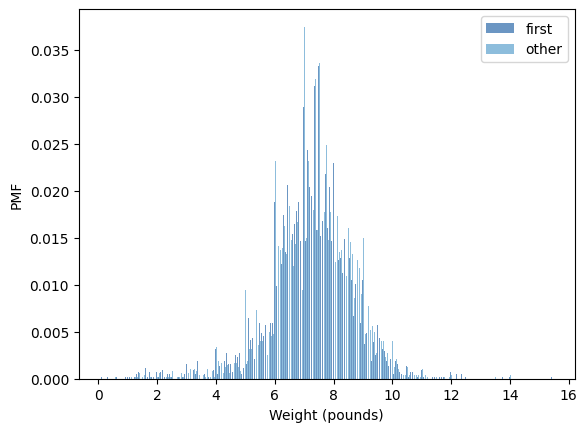

In [5]:
width = 0.4 / 16

# plot PMFs of birth weights for first babies and others
thinkplot.PrePlot(2)
thinkplot.Hist(first_pmf, align='right', width=width)
thinkplot.Hist(other_pmf, align='left', width=width)
thinkplot.Config(xlabel='Weight (pounds)', ylabel='PMF')

Overall, these distributions resemble the bell shape of a normal
distribution, with many values near the mean and a few values much
higher and lower.

But parts of this figure are hard to interpret. There are many spikes
and valleys, and some apparent differences between the distributions. It
is hard to tell which of these features are meaningful. Also, it is hard
to see overall patterns; for example, which distribution do you think
has the higher mean?

These problems can be mitigated by binning the data; that is, dividing
the range of values into non-overlapping intervals and counting the
number of values in each bin. Binning can be useful, but it is tricky to
get the size of the bins right. If they are big enough to smooth out
noise, they might also smooth out useful information.

An alternative that avoids these problems is the cumulative distribution
function (CDF), which is the subject of this chapter. But before I can
explain CDFs, I have to explain percentiles.

## Percentiles

If you have taken a standardized test, you probably got your results in
the form of a raw score and a **percentile rank**. In this context, the
percentile rank is the fraction of people who scored lower than you (or
the same). So if you are "in the 90th percentile," you did as well as or
better than 90% of the people who took the exam.

Here's how you could compute the percentile rank of a value,
`your_score`, relative to the values in the sequence `scores`:

In [6]:
def PercentileRank(scores, your_score):
    count = 0
    for score in scores:
        if score <= your_score:
            count += 1

    percentile_rank = 100.0 * count / len(scores)
    return percentile_rank

As an example, if the scores in the sequence were 55, 66, 77, 88 and 99,
and you got the 88, then your percentile rank would be `100 * 4 / 5`
which is 80.

In [8]:
t = [55, 66, 77, 88, 99]

In [9]:
PercentileRank(t, 88)

80.0

If you are given a value, it is easy to find its percentile rank; going
the other way is slightly harder. If you are given a percentile rank and
you want to find the corresponding value, one option is to sort the
values and search for the one you want:

In [7]:
def Percentile(scores, percentile_rank):
    scores.sort()
    for score in scores:
        if PercentileRank(scores, score) >= percentile_rank:
            return score

The result of this calculation is a **percentile**. For example, the
50th percentile is the value with percentile rank 50. In the
distribution of exam scores, the 50th percentile is 77.

In [10]:
Percentile(t, 50)

77

This implementation of `Percentile` is not efficient. A better approach
is to use the percentile rank to compute the index of the corresponding
percentile:

In [11]:
def Percentile2(scores, percentile_rank):
    scores.sort()
    index = percentile_rank * (len(scores)-1) // 100
    return scores[index]

In [13]:
Percentile2(t, 50)

77

The difference between "percentile" and "percentile rank" can be
confusing, and people do not always use the terms precisely. To
summarize, `PercentileRank` takes a value and computes its percentile
rank in a set of values; `Percentile` takes a percentile rank and
computes the corresponding value.

## CDFs

Now that we understand percentiles and percentile ranks, we are ready to
tackle the **cumulative distribution function** (CDF). The CDF is the
function that maps from a value to its percentile rank.

The CDF is a function of $x$, where $x$ is any value that might appear
in the distribution. To evaluate $CDF(x)$ for a particular value of
$x$, we compute the fraction of values in the distribution less than or
equal to $x$.

Here's what that looks like as a function that takes a sequence,
`sample`, and a value, `x`:

In [14]:
def EvalCdf(sample, x):
    count = 0.0
    for value in sample:
        if value <= x:
            count += 1

    prob = count / len(sample)
    return prob

This function is almost identical to `PercentileRank`, except that the
result is a probability in the range 0--1 rather than a percentile rank
in the range 0--100.

As an example, suppose we collect a sample with the values
`[1, 2, 2, 3, 5]`. Here are some values from its CDF: $$CDF(0) = 0$$
$$CDF(1) = 0.2$$ $$CDF(2) = 0.6$$ $$CDF(3) = 0.8$$ $$CDF(4) = 0.8$$
$$CDF(5) = 1$$ We can evaluate the CDF for any value of $x$, not just
values that appear in the sample. If $x$ is less than the smallest value
in the sample, $CDF(x)$ is 0. If $x$ is greater than the largest value,
$CDF(x)$ is 1.


In [15]:
t = [1, 2, 2, 3, 5]

EvalCdf(t, 0), EvalCdf(t, 1), EvalCdf(t, 2), EvalCdf(t, 3), EvalCdf(t, 4), EvalCdf(t, 5)

(0.0, 0.2, 0.6, 0.8, 0.8, 1.0)

Figure [\[example_cdf\]](#example_cdf){reference-type="ref"
reference="example_cdf"} is a graphical representation of this CDF. The
CDF of a sample is a step function.

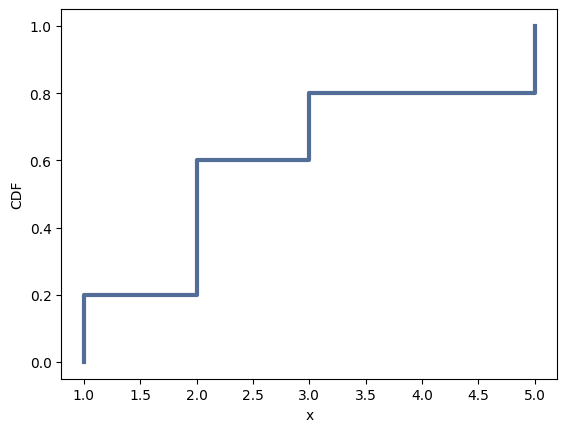

In [17]:
cdf = thinkstats2.Cdf(t)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='x', ylabel='CDF', loc='upper left')

## Representing CDFs

`thinkstats2` provides a class named Cdf that represents CDFs. The
fundamental methods Cdf provides are:

-   `Prob(x)`: Given a value `x`, computes the probability
    $p = CDF(x)$. The bracket operator is equivalent to `Prob`.

-   `Value(p)`: Given a probability `p`, computes the corresponding
    value, `x`; that is, the **inverse CDF** of `p`.

The Cdf constructor can take as an argument a list of values, a pandas
Series, a Hist, Pmf, or another Cdf. The following code makes a Cdf for
the distribution of pregnancy lengths in the NSFG:

In [31]:
cdf = thinkstats2.Cdf(live.prglngth, label='prglngth')

`thinkplot` provides a function named `Cdf` that plots Cdfs as lines:

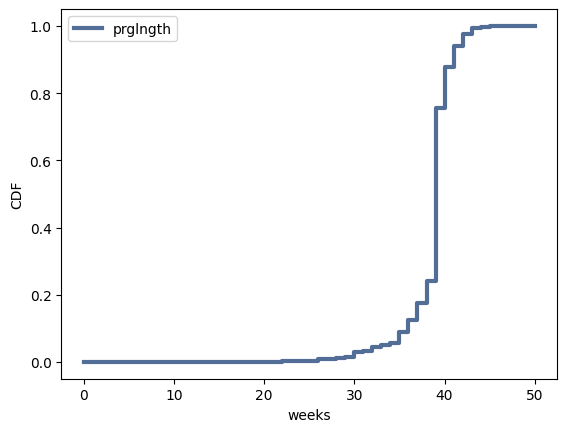

<Figure size 800x600 with 0 Axes>

In [32]:
thinkplot.Cdf(cdf)
thinkplot.Show(xlabel='weeks', ylabel='CDF')

Figure [\[cumulative_prglngth_cdf\]](#cumulative_prglngth_cdf){reference-type="ref"
reference="cumulative_prglngth_cdf"} shows the result. One way to read a
CDF is to look up percentiles. For example, it looks like about 10% of
pregnancies are shorter than 36 weeks, and about 90% are shorter than 41
weeks. The CDF also provides a visual representation of the shape of the
distribution. Common values appear as steep or vertical sections of the
CDF; in this example, the mode at 39 weeks is apparent. There are few
values below 30 weeks, so the CDF in this range is flat.

It takes some time to get used to CDFs, but once you do, I think you
will find that they show more information, more clearly, than PMFs.

`Cdf` provides `Prob`, which evaluates the CDF; that is, it computes the fraction of values less than or equal to the given value.  For example, 94% of pregnancy lengths are less than or equal to 41.

In [33]:
cdf.Prob(41)

0.9406427634455619

`Value` evaluates the inverse CDF; given a fraction, it computes the corresponding value.  For example, the median is the value that corresponds to 0.5.

In [34]:
cdf.Value(0.5)

39

## Comparing CDFs

CDFs are especially useful for comparing distributions. For example,
here is the code that plots the CDF of birth weight for first babies and
others.

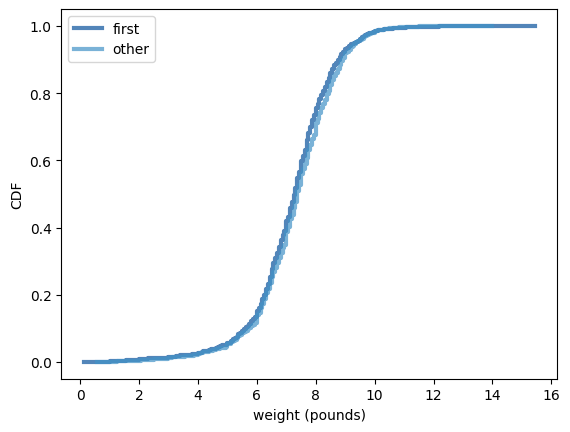

<Figure size 800x600 with 0 Axes>

In [22]:
first_cdf = thinkstats2.Cdf(firsts.totalwgt_lb, label='first')
other_cdf = thinkstats2.Cdf(others.totalwgt_lb, label='other')

thinkplot.PrePlot(2)
thinkplot.Cdfs([first_cdf, other_cdf])
thinkplot.Show(xlabel='weight (pounds)', ylabel='CDF')

Compared to
Figure [\[nsfg_birthwgt_pmf\]](#nsfg_birthwgt_pmf){reference-type="ref"
reference="nsfg_birthwgt_pmf"}, this figure makes the shape of the
distributions, and the differences between them, much clearer. We can
see that first babies are slightly lighter throughout the distribution,
with a larger discrepancy above the mean.

## Percentile-based statistics

Once you have computed a CDF, it is easy to compute percentiles and
percentile ranks. The Cdf class provides these two methods:

-   `PercentileRank(x)`: Given a value `x`, computes its percentile
    rank, $100 \cdot CDF(x)$.

-   `Percentile(p)`: Given a percentile rank `p`, computes the
    corresponding value, `x`. Equivalent to `Value(p/100)`.

`Percentile` can be used to compute percentile-based summary statistics.
For example, the 50th percentile is the value that divides the
distribution in half, also known as the **median**. Like the mean, the
median is a measure of the central tendency of a distribution.

In [36]:
weights = live.totalwgt_lb
live_cdf = thinkstats2.Cdf(weights, label='live')

In [37]:
median = live_cdf.Percentile(50)
median

7.375

Actually, there are several definitions of "median," each with different
properties. But `Percentile(50)` is simple and efficient to compute.

Another percentile-based statistic is the **interquartile range** (IQR),
which is a measure of the spread of a distribution. The IQR is the
difference between the 75th and 25th percentiles.

In [38]:
iqr = (live_cdf.Percentile(25), live_cdf.Percentile(75))
iqr

(6.5, 8.125)

More generally, percentiles are often used to summarize the shape of a
distribution. For example, the distribution of income is often reported
in "quintiles"; that is, it is split at the 20th, 40th, 60th and 80th
percentiles. Other distributions are divided into ten "deciles".
Statistics like these that represent equally-spaced points in a CDF are
called **quantiles**. For more, see
<https://en.wikipedia.org/wiki/Quantile>.

## Random numbers

Suppose we choose a random sample from the population of live births and
look up the percentile rank of their birth weights. Now suppose we
compute the CDF of the percentile ranks. What do you think the
distribution will look like?

Here's how we can compute it. First, we make the Cdf of birth weights:

In [23]:
weights = live.totalwgt_lb
cdf = thinkstats2.Cdf(weights, label='totalwgt_lb')

Then we generate a sample and compute the percentile rank of each value
in the sample.

In [25]:
import numpy as np

sample = np.random.choice(weights, 100, replace=True)
ranks = [cdf.PercentileRank(x) for x in sample]

`sample` is a random sample of 100 birth weights, chosen with
**replacement**; that is, the same value could be chosen more than once.
`ranks` is a list of percentile ranks.

Finally we make and plot the Cdf of the percentile ranks.

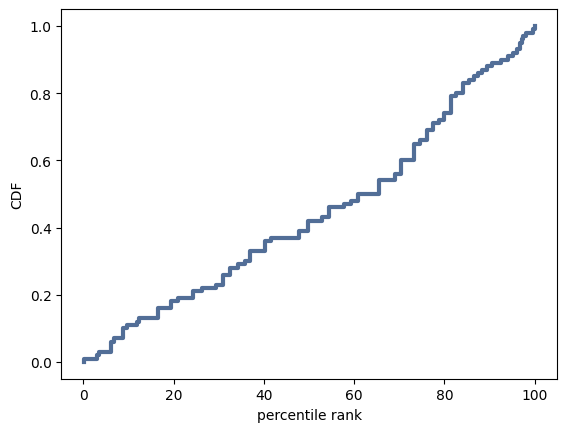

<Figure size 800x600 with 0 Axes>

In [26]:
rank_cdf = thinkstats2.Cdf(ranks)
thinkplot.Cdf(rank_cdf)
thinkplot.Show(xlabel='percentile rank', ylabel='CDF')

This figure shows the result. The CDF is
approximately a straight line, which means that the distribution is
uniform.

That outcome might be non-obvious, but it is a consequence of the way
the CDF is defined. What this figure shows is that 10% of the sample is
below the 10th percentile, 20% is below the 20th percentile, and so on,
exactly as we should expect.

So, regardless of the shape of the CDF, the distribution of percentile
ranks is uniform. This property is useful, because it is the basis of a
simple and efficient algorithm for generating random numbers with a
given CDF. Here's how:

-   Choose a percentile rank uniformly from the range 0--100.

-   Use `Cdf.Percentile` to find the value in the distribution that
    corresponds to the percentile rank you chose.

Cdf provides an implementation of this algorithm, called `Random`:

In [28]:
def Random(self):
    return self.Percentile(random.uniform(0, 100))

Cdf also provides `Sample`, which takes an integer, `n`, and returns a
list of `n` values chosen at random from the Cdf.

## Comparing percentile ranks

Percentile ranks are useful for comparing measurements across different
groups. For example, people who compete in foot races are usually
grouped by age and gender. To compare people in different age groups,
you can convert race times to percentile ranks.

A few years ago I ran the James Joyce Ramble 10K in Dedham MA; I
finished in 42:44, which was 97th in a field of 1633. I beat or tied
1537 runners out of 1633, so my percentile rank in the field is 94%.

More generally, given position and field size, we can compute percentile
rank:

In [39]:
def PositionToPercentile(position, field_size):
    beat = field_size - position + 1
    percentile = 100.0 * beat / field_size
    return percentile

In my age group, denoted M4049 for "male between 40 and 49 years of
age", I came in 26th out of 256. So my percentile rank in my age group
was 90%.

If I am still running in 10 years (and I hope I am), I will be in the
M5059 division. Assuming that my percentile rank in my division is the
same, how much slower should I expect to be?

I can answer that question by converting my percentile rank in M4049 to
a position in M5059. Here's the code:

In [40]:
def PercentileToPosition(percentile, field_size):
    beat = percentile * field_size / 100.0
    position = field_size - beat + 1
    return position

There were 171 people in M5059, so I would have to come in between 17th
and 18th place to have the same percentile rank. The finishing time of
the 17th runner in M5059 was 46:05, so that's the time I will have to
beat to maintain my percentile rank.

## Glossary

-   **percentile rank**: The percentage of values in a distribution that
    are less than or equal to a given value.

-   **percentile**: The value associated with a given percentile rank.

-   **cumulative distribution function (CDF)**: A function that maps
    from values to their cumulative probabilities. $CDF(x)$ is the
    fraction of the sample less than or equal to $x$.

-   **inverse CDF**: A function that maps from a cumulative probability,
    $p$, to the corresponding value.

-   **median**: The 50th percentile, often used as a measure of central
    tendency.

-   **interquartile range**: The difference between the 75th and 25th
    percentiles, used as a measure of spread.

-   **quantile**: A sequence of values that correspond to equally spaced
    percentile ranks; for example, the quartiles of a distribution are
    the 25th, 50th and 75th percentiles.

-   **replacement**: A property of a sampling process. "With
    replacement" means that the same value can be chosen more than once;
    "without replacement" means that once a value is chosen, it is
    removed from the population.

## Exercises

**Exercise:** How much did you weigh at birth? If you don’t know, call your mother or someone else who knows. Using the NSFG data (all live births), compute the distribution of birth weights and use it to find your percentile rank. If you were a first baby, find your percentile rank in the distribution for first babies. Otherwise use the distribution for others. If you are in the 90th percentile or higher, call your mother back and apologize.

In [41]:
# Solution

first_cdf.PercentileRank(8.5)

85.90419436167774

In [42]:
# Solution

other_cdf.PercentileRank(8.5)

82.35294117647058

**Exercise:** The numbers generated by `numpy.random.random` are supposed to be uniform between 0 and 1; that is, every value in the range should have the same probability.

Generate 1000 numbers from `numpy.random.random` and plot their PMF.  What goes wrong?

Now plot the CDF. Is the distribution uniform?

In [43]:
# Solution

t = np.random.random(1000)

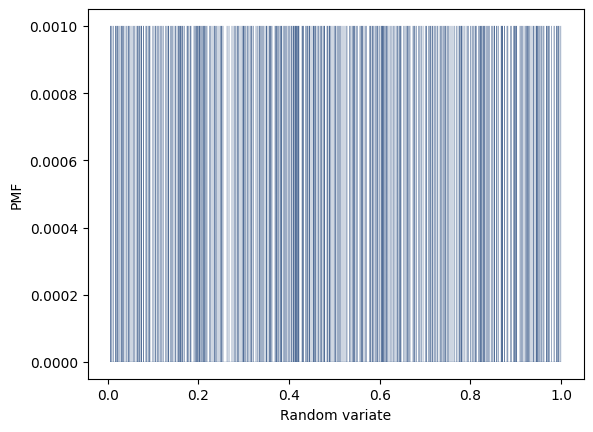

In [44]:
# Solution

pmf = thinkstats2.Pmf(t)
thinkplot.Pmf(pmf, linewidth=0.1)
thinkplot.Config(xlabel='Random variate', ylabel='PMF')

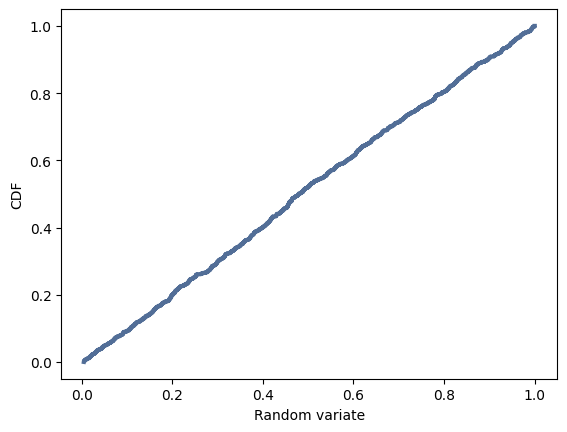

In [45]:
# Solution

cdf = thinkstats2.Cdf(t)
thinkplot.Cdf(cdf)
thinkplot.Config(xlabel='Random variate', ylabel='CDF')